# Introduction

The following notebook describes the basics on how the repository is structured. The first lines are used to initialize the Julia project and Julia packages.

In [1]:
; cd ..

/Users/rhenriquez/Github_Projects/InverterDynamicLinesModels


In [2]:
] activate

 Activating environment at `~/Github_Projects/InverterDynamicLinesModels/Project.toml`


In [3]:
] instantiate

In [4]:
using Plots
include(joinpath(pwd(), "InverterDynamicLinesModels", "InverterDynamicLinesModels.jl"))

In [5]:
using PowerSystems

The following describes the procedure to create the dynamic model. The first step is to initialize the inverter via `PowerSystems.jl`, and then defining the dynamic model, Jacobian and Small Signal Analysis

In [7]:
# Load Data with PF solution from file
omib_sys = System(joinpath(pwd(), "data", "OMIB_inverter.json"));

┌ Info: Loaded time series from storage file existing=OMIB_inverter_time_series_storage.h5 new=/var/folders/fz/6cnhcl5n2dggz6f6c_l54g740000gn/T/jl_X4v3cx
└ @ InfrastructureSystems /Users/rhenriquez/.julia/packages/InfrastructureSystems/uydla/src/hdf5_time_series_storage.jl:72
┌ Warning: There are no Generator Components in the System
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/Ihfxp/src/utils/IO/system_checks.jl:56
┌ Warning: There are no ElectricLoad Components in the System
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/Ihfxp/src/utils/IO/system_checks.jl:56


## Create VSM Model with Dynamic Lines

The next step initialize the parameters of the system. The parameters used can be found in: `InverterDynamicLinesModels/utils/parameters.jl`.

All models can be found in `InverterDynamicLinesModels/models/`

In [8]:
# Instantiate analysis objects: parameters and model 
#Instantiate Parameters for VSM model
parameter_mapping = instantiate_parameters(VInertia, omib_sys)
#Instantiate VSM Model with DynamicLines
M_vsm = instantiate_model(VInertia, DynamicLines, omib_sys)

ModelOperatingPoint


In [9]:
#Instantiate initial conditions for given parameters
u0 = M_vsm(parameter_mapping); # works as a test, not really necessary to call

In [10]:
#Instantiate Jacobian
jac_exp_vsm = get_jacobian_function(VInertia, DynamicLines);
fjac_vsm = eval(jac_exp_vsm);
jac_vsm = instantiate_jacobian(M_vsm, fjac_vsm);

In [11]:
#Instantiate Small Signal Object
ss_vsm = instantiate_small_signal(M_vsm, jac_vsm)
#Update Small Signal Object
ss_vsm(M_vsm, jac_vsm)

In [12]:
#Show Eigenvalues
ss_vsm.eigen_vals

19-element Array{Complex{Float64},1}:
  -2711.9518134731707 - 381.7153882733633im
  -2711.9518134731707 + 381.7153882733633im
   -1313.813831723322 - 8046.538649860838im
   -1313.813831723322 + 8046.538649860838im
  -1297.4097036238659 - 8310.016922938752im
  -1297.4097036238659 + 8310.016922938752im
  -1000.4665174000181 - 4.662550434772237im
  -1000.4665174000181 + 4.662550434772237im
   -884.8060496173138 - 4855.415223878914im
   -884.8060496173138 + 4855.415223878914im
   -701.0166379133655 - 4147.600832316531im
   -701.0166379133655 + 4147.600832316531im
  -111.58549646658932 - 153.34274889444453im
  -111.58549646658932 + 153.34274889444453im
  -20.614221788374156 + 0.0im
  -11.491590000516316 + 0.0im
  -11.299856536948557 + 0.0im
 -0.05305336322635412 - 2.111154388830497e8im
 -0.05305336322635412 + 2.111154388830497e8im

As can be seen, there are 19 eigenvalues associated with the 19 states. There seems to be a bad eigenvalue close to zero, but, we will see that that eigenvalue is associated with the infinite bus, and do not vary due to the small equivalent reactance. 

### Show Participation Factors
Rows represents states while columns represent modes (eigenvalues).

For example `ss_vsm.participation_factors[:,end]` shows the participation factors of each state in the eigenvalue with highest real part. Order of states is as follows:
```
1) il_r(t)         # real current flowing in line
2) il_i(t)         # imaginary current flowing in line
3) vg_from_r(t)    # real voltage from-side of line
4) vg_from_i(t)    # imaginary voltage from-side of line
5) vg_to_r(t)      # real voltage to-side of line (inf bus)
6) vg_to_i(t)      # imaginary voltage to-side of line (inf bus)
# Filter States
7) ef_d(t)         # d-axis capacitor filter voltage
8) ef_q(t)         # q-axis capacitor filter voltage
9) ic_d(t)         # d-axis current flowing into filter
10) ic_q(t)        # q-axis current flowing into filter
11) if_d(t)        # d-axis flowing out of the filter
12) if_q(t)        # q-axis current flowing out of the filter
# Inner Loop Control States
13) ξ_d(t)         # d-axis integrator term for voltage PI controller
14) ξ_q(t)         # q-axis integrator term for voltage PI controller
15) γ_d(t)         # d-axis integrator term for current PI controller
16) γ_q(t)         # q-axis integrator term for current PI controller
# VSM Control States
17) θ(t)           # Outer Control Angle
18) ω(t)           # Outer Control Frequency
19) qf(t)          # Filtered Reactive Power
```

In [13]:
round.(ss_vsm.participation_factors[:,end]; digits=4)

19-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.5
 0.5
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In here we observe that the the states 5 and 6 (voltage to-side of the line) are the ones participating in that mode (19th eigenvalue).

The following objects can be obtained from the small signal analysis:
- `ss_vsm.eigen_vals`: $ \lambda $ reports the eigenvalues of the system
- `ss.vsm.R_eigen_vect`: $\Phi$ reports the right eigenvectors (or simply the eigenvectors) of the jacobian
- `ss.vsm.L_eigen_vect`: $\Psi$ reports the inverse of the right eigenvectors.
- `ss.vsm.participation_factors`: Reports the normalized participation factors computed as $|\Phi \odot \Psi^*|$
- `ss.vsm_damping_vectors`: Reports the damping of each eigenvalue

## Create VSM model with Static (or Algebraic) Lines

The following defines the model with algebraic lines. In this case, states associated with the lines, 1 through 6, are treated as algebraic variables and hence removed from the reduced Jacobian

In [14]:
# Instantiate analysis objects: parameters and model 
#Instantiate Parameters for VSM model
parameter_mapping = instantiate_parameters(VInertia, omib_sys)
#Instantiate VSM Model with AlgebraicLines
M_vsm = instantiate_model(VInertia, StaticLines, omib_sys)
#Instantiate initial conditions for given parameters
u0 = M_vsm(parameter_mapping); # works as a test, not really necessary to call
#Instantiate Jacobian
jac_exp_vsm = get_jacobian_function(VInertia, StaticLines);
fjac_vsm = eval(jac_exp_vsm);
jac_vsm = instantiate_jacobian(M_vsm, fjac_vsm);
#Instantiate Small Signal Object
ss_vsm = instantiate_small_signal(M_vsm, jac_vsm)
#Update Small Signal Object
ss_vsm(M_vsm, jac_vsm)
#Show Eigenvalues
ss_vsm.eigen_vals

13-element Array{Complex{Float64},1}:
 -3433.8857057129026 - 563.5310076922453im
 -3433.8857057129026 + 563.5310076922453im
 -1755.6161462950795 - 7799.466701034019im
 -1755.6161462950795 + 7799.466701034019im
  -1700.118561208813 - 7450.62256294853im
  -1700.118561208813 + 7450.62256294853im
 -1000.4144626977107 - 4.203976975915929im
 -1000.4144626977107 + 4.203976975915929im
 -125.54706710460209 - 160.10868916863015im
 -125.54706710460209 + 160.10868916863015im
 -20.456302058785568 + 0.0im
  -11.49179848100656 + 0.0im
 -11.299557173143363 + 0.0im

As can be seen here, only 13 eigenvalues are showed, since 6 states associated with the lines were removed.

## Create VSM model with AC-side Algebraic (`ACStatic`)

That is highly dependent on state 13, current controller integrator `γ_d` on the d-axis

In [15]:
# Instantiate analysis objects: parameters and model 
#Instantiate Parameters for VSM model
parameter_mapping = instantiate_parameters(VInertia, omib_sys)
#Instantiate VSM Model with AlgebraicLines
M_vsm = instantiate_model(VInertia, ACStatic, omib_sys)
#Instantiate initial conditions for given parameters
u0 = M_vsm(parameter_mapping); # works as a test, not really necessary to call
#Instantiate Jacobian
jac_exp_vsm = get_jacobian_function(VInertia, ACStatic);
fjac_vsm = eval(jac_exp_vsm);
jac_vsm = instantiate_jacobian(M_vsm, fjac_vsm);
#Instantiate Small Signal Object
ss_vsm = instantiate_small_signal(M_vsm, jac_vsm)
#Update Small Signal Object
ss_vsm(M_vsm, jac_vsm)
#Show Eigenvalues
ss_vsm.eigen_vals

7-element Array{Complex{Float64},1}:
 -1000.5204115298741 - 3.9970819383118767im
 -1000.5204115298741 + 3.9970819383118767im
 -144.16345982444736 - 158.1217142993882im
 -144.16345982444736 + 158.1217142993882im
 -20.318695764669382 + 0.0im
 -11.491400635274566 + 0.0im
 -11.298529298839494 + 0.0im

Finally, this reports only 7 eigenvalues, only associated with the internal inverter states.

## Run a Transient Simulation

In [18]:
using OrdinaryDiffEq #Gets the solvers

In here we will show a transient simulation run for a step change on `P_ref` from 0.5 to 0.65

In [24]:
#### VSM model with Full Lines ####
#Instantiate VSM Model with DynamicLines
M_vsm = instantiate_model(VInertia, DynamicLines, omib_sys)
#Instantiate Jacobian
jac_exp_vsm = get_jacobian_function(VInertia, DynamicLines);
fjac_vsm = eval(jac_exp_vsm);
jac_vsm = instantiate_jacobian(M_vsm, fjac_vsm)

Jacobian


In [38]:
#Increase P_ref from 0.5 to 0.65
ode_vsm = instantiate_ode(M_vsm, PowerOutputIncrease(time = 1.0, new_value = 0.65); tspan = (0.0, 1.5))
sol_vsm = solve(ode_vsm, GRK4T(), dtmax=1e-4);

In [28]:
v0d_index = 7
v0q_index = 8
i0d_index = 11
i0q_index = 12

t = sol_vsm.t
v0d = [value[v0d_index] for value in sol_vsm.u];
v0q = [value[v0q_index] for value in sol_vsm.u];
i0d = [value[i0d_index] for value in sol_vsm.u];
i0q = [value[i0q_index] for value in sol_vsm.u];
p = v0d .* i0d + v0q .* i0q;
vmag = sqrt.(v0d.^2 + v0q.^2);

15012-element Array{Float64,1}:
 1.0667685333075851
 1.0667685333075834
 1.0667685333075811
 1.0667685333075814
 1.066768533307585
 1.0667685333075887
 1.0667685333075896
 1.0667685333075856
 1.0667685333075771
 1.0667685333075676
 1.0667685333075607
 1.066768533307558
 1.0667685333075598
 ⋮
 1.0799809959645585
 1.0799809956893658
 1.0799809954136195
 1.0799809951373212
 1.0799809948604744
 1.0799809945830812
 1.0799809943051442
 1.0799809940266658
 1.079980993747648
 1.079980993468094
 1.0799809931880058
 1.0799809931763669

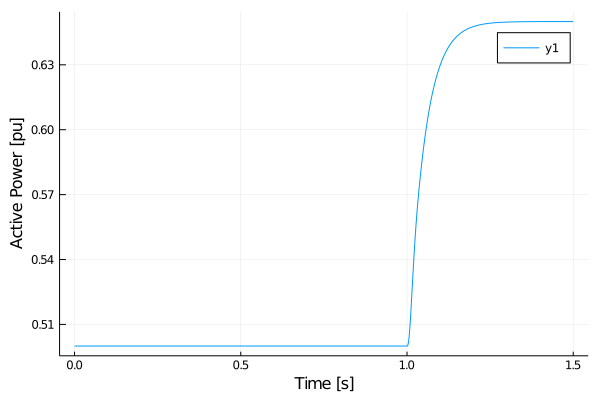

In [37]:
plot(t,p)
plot!(xlabel = "Time [s]", ylabel="Active Power [pu]")

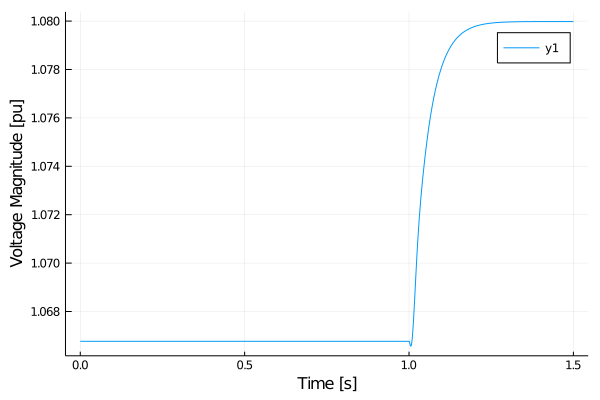

In [36]:
plot(t, vmag)
plot!(xlabel = "Time [s]", ylabel="Voltage Magnitude [pu]")

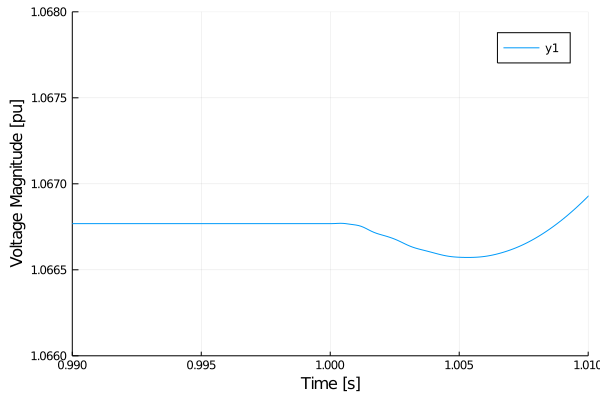

In [35]:
plot(t, vmag)
plot!(xlim=(0.99, 1.01))
plot!(ylim=(1.066, 1.068))
plot!(xlabel = "Time [s]", ylabel="Voltage Magnitude [pu]")